In [ ]:
#Importing Dependencies

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [ ]:
mv_reviews = pd.read_csv("IMDB Dataset.csv")

In [ ]:
mv_reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
mv_reviews.shape

(50000, 2)

In [ ]:
mv_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

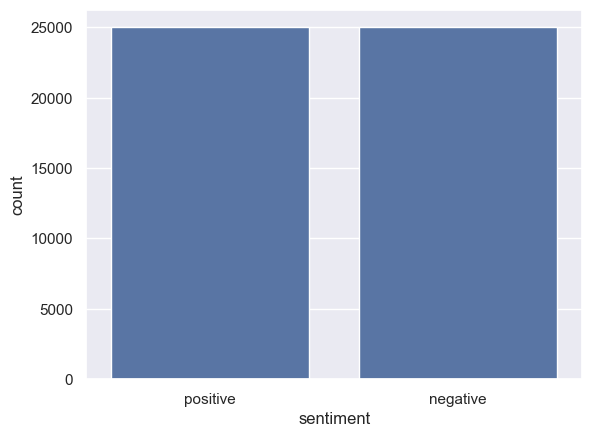

In [ ]:
import seaborn as sns
sns.set()
sns.countplot(x='sentiment', data=mv_reviews)

In [ ]:
mv_reviews["review"][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\vekkudu
[nltk_data]     naveen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
#Initializing preprocessing_text function on mv_reviews

X = []
sentences = list(mv_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
# Looking for Sample cleaned up movie review

X[5]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'probably time favorite movie story selflessness sacrifice dedication noble cause preachy boring never gets old despite seen times last years paul lukas performance brings tears eyes bette davis one truly sympathetic roles delight kids grandma says like dressed midgets children makes fun watch mother slow awakening happening world roof believable startling dozen thumbs movie '

In [ ]:
# Converting sentiment labels to 0 & 1

y = mv_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(92394, 100)

In [ ]:
#Neural Network Architecture
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


nn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

nn_model.add(embedding_layer)

nn_model.add(Flatten())
nn_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['acc'])


print(nn_model.summary())

nn_model_history = nn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2, callbacks=[EarlyStopping(patience=2)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9879529 (37.69 MB)
Trainable params: 640129 (2.44 MB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/10
250/250 [==============================] - 4s 14ms/step - loss: 0.8055 - acc: 0.7053 - val_loss: 0.5982 - val_acc: 0.7586
Epoch 2

In [ ]:
# Predictions on the Test Set

score = nn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.6012 - acc: 0.7510


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6011955738067627
Test Accuracy: 0.7509999871253967


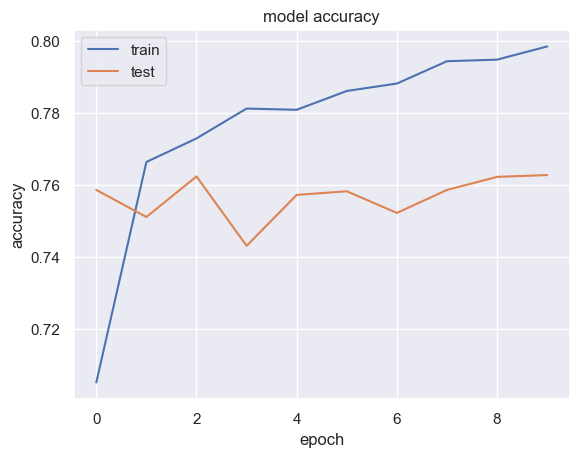

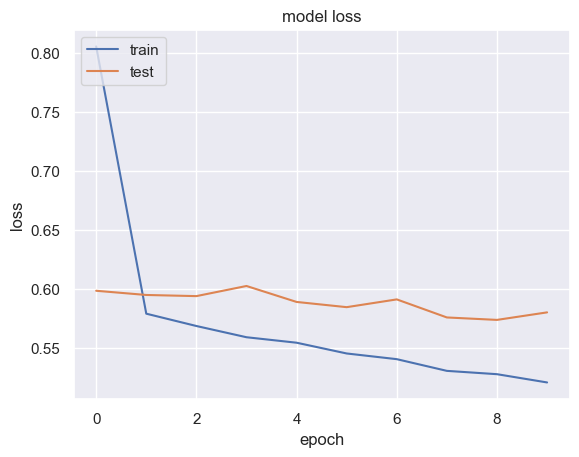

In [ ]:
import matplotlib.pyplot as plt

plt.plot(nn_model_history.history['acc'])
plt.plot(nn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(nn_model_history.history['loss'])
plt.plot(nn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


In [ ]:
#Convolutional Neural Network architecture

from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, GlobalMaxPooling1D

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

print(cnn_model.summary())

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2, callbacks=[EarlyStopping(patience=2)])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/10
250/250 [==============================] - 10s 35ms/step - l

In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 2s 6ms/step - loss: 0.4419 - acc: 0.8454


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4419093132019043
Test Accuracy: 0.8453999757766724


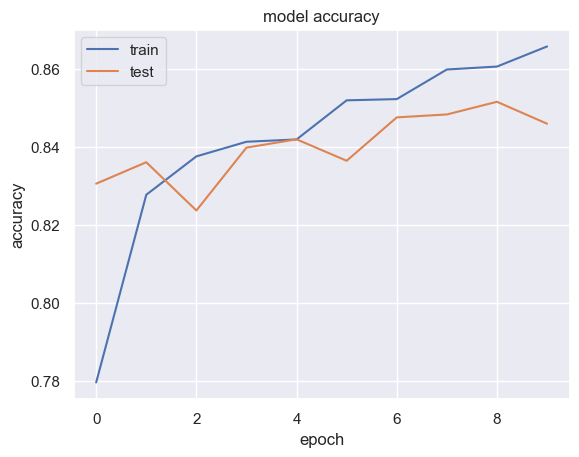

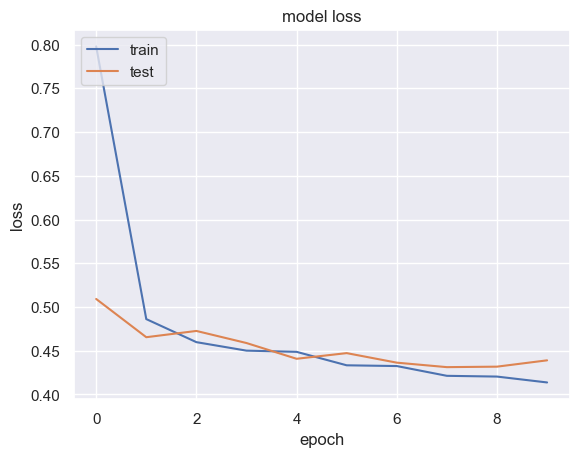

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
# Recurrent Neural Network architecture

from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import LSTM

lstm_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
lstm_model.add(embedding_layer)

lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

print(lstm_model.summary())

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/6
250/250 [==============================] - 60s 230ms/step - loss: 0.5050 - acc: 0.7530 - val_loss: 0.4258 - val_acc: 0.8123
Epoch 2/6
250/250 [==============================] - 62s 246ms/step - loss: 0.4138 - acc: 0.8155 - val_loss: 0.4038 - val_acc: 0.8319


In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 6s 20ms/step - loss: 0.3105 - acc: 0.8662


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.31054630875587463
Test Accuracy: 0.8661999702453613


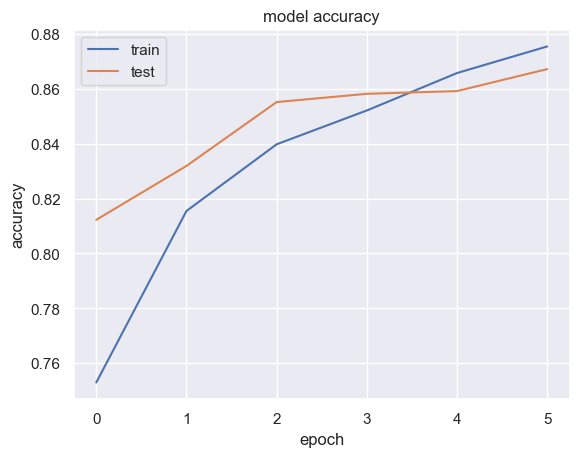

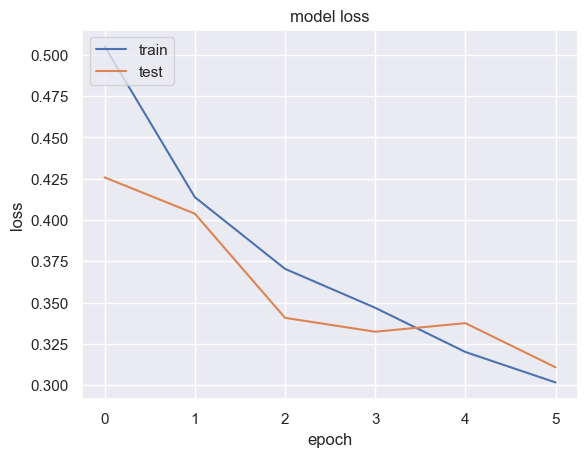

In [ ]:
# Model Performance Charts


plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


In [ ]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_Lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

C:\Users\vekkudu naveen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [ ]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 0s 480ms/step


array([[0.8567016 ],
       [0.9899078 ],
       [0.10935952],
       [0.7451177 ],
       [0.96416646],
       [0.01640477]], dtype=float32)

In [ ]:
#Generating predictions for the sentiment of the unseen reviews using the LSTM model

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.6
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.1
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,7.5
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.6
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.2
